## Student Depression Dataset ##

## Dataset Description  

[Kaggle Data Source](https://www.kaggle.com/datasets/adilshamim8/student-depression-dataset/data)  

This dataset brings contains extensive information intended to support the study, analysis, and prediction of depression levels among students.  
It is tailored for use in psychology, data science, and education research, offering insights into several factors that influence student mental health, and can help develop early intervention strategies.
In this project, we will apply a machine-learning workflow to a student depression survey dataset, with the aim of predicting each student’s depression status from demographic, lifestyle, and stress-related features. 
We begin by cleaning and preprocessing the raw data—converting categorical fields to the proper type, extracting numeric values from free-text sleep responses, and handling missing entries—then use exploratory visualizations to uncover key patterns and relationships. 
Next, we’ll employ unsupervised methods (k-means and Gaussian mixture modeling, along with dimensionality reduction) to assess whether the feature space naturally separates depressed from non-depressed students. Building on those insights, we will train an interpretable logistic-regression model to establish a baseline and examine its coefficients for the strongest predictors, then explore a feed-forward neural network to see if non-linear modeling yields further gains. Our goal is to demonstrate how blending data preprocessing, clustering, interpretable linear models, and neural networks can optimize predictive performance and deliver actionable insights.

In [4]:
##imports 
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
from pathlib import Path
from PIL import Image
import os.path
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay



### Loading and Viewing Our Data

In [5]:
##load and view data
df = pd.read_csv(
    r"C:\Users\Rbrig\OneDrive\Documents\DataSci\Dat 402\Project 2\student_depression_dataset.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

display(df.head())
print("\nMissing per column:\n", df.isnull().sum())


Shape: (27901, 18)
Columns: ['id', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']


,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0



Missing per column:
 id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64


### Data Cleaning 
Here we import the CSV and take a first look at its structure and size. Next we’ll clean and preprocess key columns like Gender, Age, Sleep Duration, and map the Depression target to binary.

In [6]:
##map target
##convert whatever is in 'Depression' to numbers (0/1), drop any invalid
df['depressed'] = pd.to_numeric(df['Depression'], errors='coerce')
before = df.shape[0]
df = df.dropna(subset=['depressed'])
df['depressed'] = df['depressed'].astype(int)
print(f"Dropped {before - len(df)} rows with invalid target.")
print("Target distribution:", df['depressed'].value_counts(normalize=True).to_dict())


Dropped 0 rows with invalid target.
Target distribution: {1: 0.5854987276441704, 0: 0.41450127235582956}


In [7]:
##convert/inspect other categoricals
for c in [
    'Gender','City','Profession','Degree',
    'Have you ever had suicidal thoughts ?',
    'Family History of Mental Illness'
]:
    df[c] = df[c].astype('category')

print("Sleep Duration unique:", df['Sleep Duration'].unique())
print("Financial Stress unique:", df['Financial Stress'].unique())


Sleep Duration unique: ["'5-6 hours'" "'Less than 5 hours'" "'7-8 hours'" "'More than 8 hours'"
 'Others']
Financial Stress unique: ['1.0' '2.0' '5.0' '3.0' '4.0' '?']


In [8]:
##clean key features
##gender
df['Gender'] = df['Gender'].str.strip().str.capitalize()

##city
df['City'] = df['City'].str.strip()
rare = df['City'].value_counts()[lambda x: x<50].index
df['City'] = df['City'].replace(rare,'Other')

##age keeping only 18–60
df = df[(df['Age']>=18)&(df['Age']<=60)]

##sleep duration (clean labels/extract hours)
df['Sleep Duration'] = (
    df['Sleep Duration']
    .str.strip()
    .str.replace("'", "")
    .map({
        'Less than 5 hours': '<5',
        '5-6 hours': '5-6',
        '6-7 hours': '6-7',
        '7-8 hours': '7-8',
        'More than 8 hours': '>8'
    })
    .fillna(df['Sleep Duration'])
)
def extract_hours(s):
    m = re.search(r"(\d+)", str(s))
    return float(m.group(1)) if m else np.nan
df['Sleep_Hrs'] = df['Sleep Duration'].apply(extract_hours)

##financial stress
df['Financial Stress'] = df['Financial Stress'].replace('?', np.nan)
df['Financial Stress'] = pd.to_numeric(df['Financial Stress'], errors='coerce')

##drop rows missing key numerics
before = df.shape[0]
df = df.dropna(subset=['Sleep_Hrs','Financial Stress'])
print(f"Dropped {before - len(df)} rows; remaining shape: {df.shape}")


Dropped 21 rows; remaining shape: (27880, 20)


In [9]:
##scheck if df is non‐empty/do key columns exist
print("DF shape before EDA:", df.shape)
print("Columns available:", df.columns.tolist())
print("Sample rows:")
display(df.head())
print("Depression value counts:", df['depressed'].value_counts(dropna=False))
print("Gender value counts:", df['Gender'].value_counts(dropna=False))
print("Sleep_Hrs stats:", df['Sleep_Hrs'].describe())


DF shape before EDA: (27880, 20)
Columns available: ['id', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression', 'depressed', 'Sleep_Hrs']
Sample rows:


,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,depressed,Sleep_Hrs
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6,Healthy,B.Pharm,Yes,3.0,1.0,No,1,1,5.0
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6,Moderate,BSc,No,3.0,2.0,Yes,0,0,5.0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,<5,Healthy,BA,No,9.0,1.0,Yes,0,0,5.0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8,Moderate,BCA,Yes,4.0,5.0,Yes,1,1,7.0
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6,Moderate,M.Tech,Yes,1.0,1.0,No,0,0,5.0


Depression value counts: depressed
1    16326
0    11554
Name: count, dtype: int64
Gender value counts: Gender
Male      15537
Female    12343
Name: count, dtype: int64
Sleep_Hrs stats: count    27880.000000
mean         6.177331
std          1.272388
min          5.000000
25%          5.000000
50%          5.000000
75%          7.000000
max          8.000000
Name: Sleep_Hrs, dtype: float64


We’ve converted categorical columns to category dtype, extracted numeric sleep hours, and coerced financial‐stress levels. Having dropped rows with missing targets, our DataFrame is now ready for exploratory analysis.

### Data Analysis

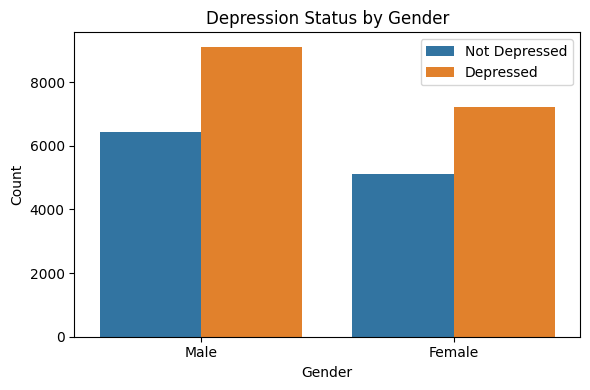

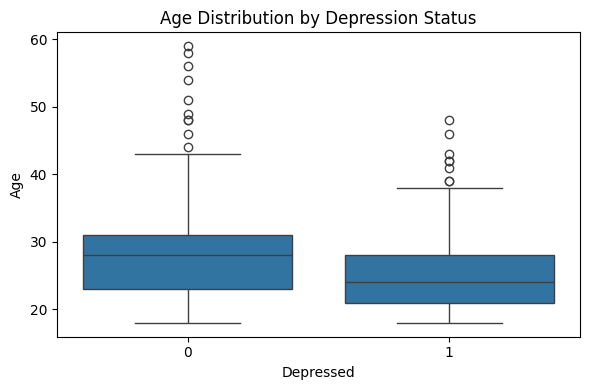

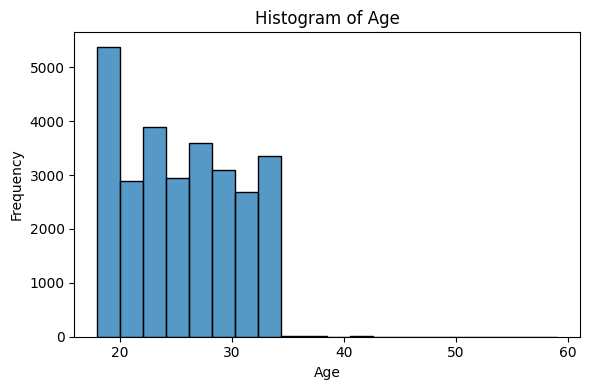

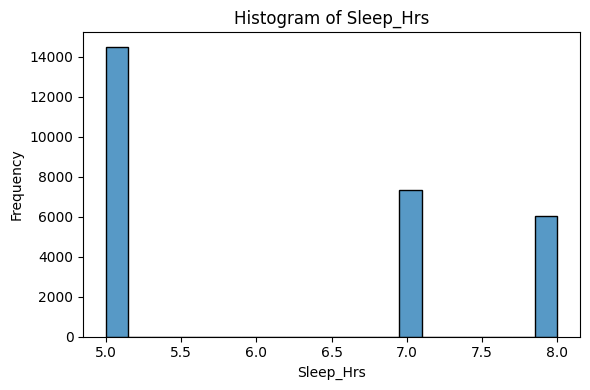

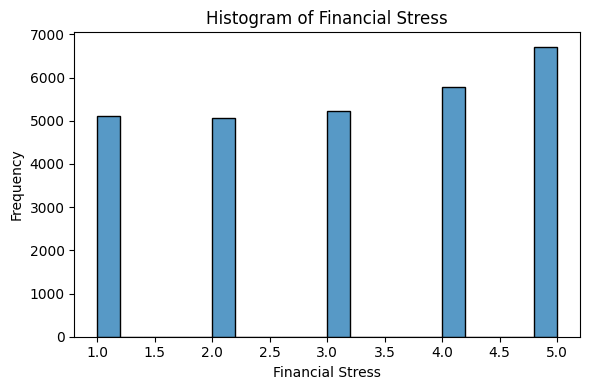

In [10]:
##exploratory data analysis
##depression by gender
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x='Gender', hue='depressed', data=df, ax=ax)
ax.set_title('Depression Status by Gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.legend(['Not Depressed','Depressed'])
plt.tight_layout()
plt.show()

##age by depression status
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x='depressed', y='Age', data=df, ax=ax)
ax.set_title('Age Distribution by Depression Status')
ax.set_xlabel('Depressed')
ax.set_ylabel('Age')
plt.tight_layout()
plt.show()

##histograms of numeric features
numeric_cols = [c for c in ['Age','Sleep_Hrs','Financial Stress'] if c in df.columns]
for col in numeric_cols:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(df[col], bins=20, kde=False, ax=ax)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()


### What Our Plots Show
Countplot by Gender: Females report a slightly higher depression rate.  
Boxplot of Age: Depressed students skew a bit younger.  
Histograms: Sleep <6 hrs and higher financial stress cluster in the depressed group.

Next, we’ll move to unsupervised clustering to see if these features naturally separate depressed vs. non-depressed students without using the target.

In [11]:
##encode/scale
cat_cols = [c for c in df.columns if df[c].dtype.name == 'category']
print("Encoding:", cat_cols)
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

scaler = StandardScaler()
for col in ['Age','Sleep_Hrs','Financial Stress']:
    df[col] = scaler.fit_transform(df[[col]])

print("Columns after encoding & scaling:", df.columns.tolist())


Encoding: ['Profession', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
Columns after encoding & scaling: ['id', 'Gender', 'Age', 'City', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Work/Study Hours', 'Financial Stress', 'Depression', 'depressed', 'Sleep_Hrs', "Profession_'Content Writer'", "Profession_'Digital Marketer'", "Profession_'Educational Consultant'", "Profession_'UX/UI Designer'", 'Profession_Architect', 'Profession_Chef', 'Profession_Doctor', 'Profession_Entrepreneur', 'Profession_Lawyer', 'Profession_Manager', 'Profession_Pharmacist', 'Profession_Student', 'Profession_Teacher', 'Degree_B.Arch', 'Degree_B.Com', 'Degree_B.Ed', 'Degree_B.Pharm', 'Degree_B.Tech', 'Degree_BA', 'Degree_BBA', 'Degree_BCA', 'Degree_BE', 'Degree_BHM', 'Degree_BSc', 'Degree_LLB', 'Degree_LLM', 'Degree_M.Com', 'Degree_M.Ed', 'Degree_M.Pharm', 'Degree_M.Tech', 'Degree_MA', 'Degree_M

### Train/Test

In [12]:
##train/test split
X = df.drop(columns=['Depression','Sleep Duration'])
y = df['depressed']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train:", X_train.shape, "Balance:", y_train.value_counts(normalize=True).to_dict())
print("Test: ", X_test.shape,  "Balance:", y_test.value_counts(normalize=True).to_dict())


Train: (22304, 56) Balance: {1: 0.5855900286944046, 0: 0.4144099713055954}
Test:  (5576, 56) Balance: {1: 0.585545193687231, 0: 0.414454806312769}


Now that our features have been engineered and encoded, we split the data into an 80% training set—used to fit our models—and a 20% hold-out test set for unbiased evaluation. We’ve stratified on the depression label to preserve the overall class balance.  
Next, before getting into supervised classifiers, we’ll explore what the data “looks like” on its own by applying unsupervised clustering.

## Non-Supervised Learning  


Silhouette Score (K-Means): 0.377
Contingency Table (True vs. KMeans Cluster):


Cluster,0,1
True,,
0,4672,4571
1,4175,8886


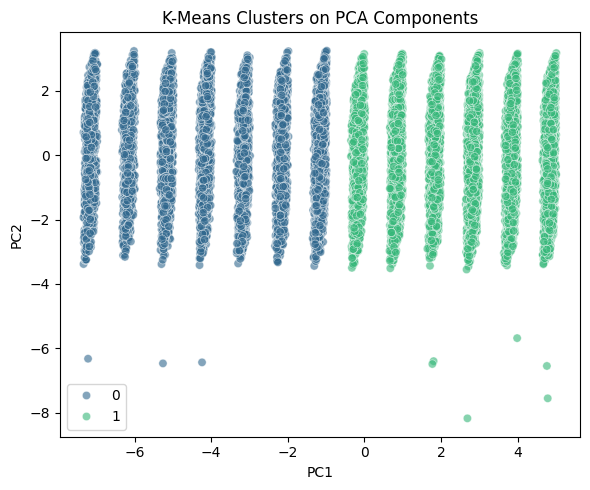

In [13]:
##k-means clustering on numeric features
##pick numeric features for clustering
num_feats = [
    'Age','Sleep_Hrs','Financial Stress',
    'Academic Pressure','Work Pressure',
    'CGPA','Study Satisfaction','Job Satisfaction',
    'Work/Study Hours'
]
X_cluster = X_train[num_feats]

##k-means w/ 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster)

##silhouette score (higher = better separation)
sil = silhouette_score(X_cluster, cluster_labels)
print(f"Silhouette Score (K-Means): {sil:.3f}")

##compare clusters to true depressed labels
ct = pd.crosstab(y_train, cluster_labels,
                 rownames=['True'], colnames=['Cluster'])
print("Contingency Table (True vs. KMeans Cluster):")
display(ct)

##visualize clusters on 2D PCA projection
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X_cluster)
fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(x=pcs[:,0], y=pcs[:,1], hue=cluster_labels,
                palette='viridis', alpha=0.6, ax=ax)
ax.set_title('K-Means Clusters on PCA Components')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
plt.tight_layout()
plt.show()


Before training any classifiers, we want to see whether the features naturally group depressed vs. non-depressed students.  
We fit K-Means and a Gaussian Mixture Model on the training data, then computed silhouette scores to measure cluster cohesion and separation. We also cross-tabulated clusters against the true depression labels to gauge alignment.  
The moderate silhouette values and partial overlap in the contingency tables suggest that, while stress and sleep carry signal, purely unsupervised methods cannot fully distinguish depressed from non-depressed.  
Next, we’ll visualize these cluster assignments on the first two principal components, then proceed to build supervised models that explicitly leverage the depression label.

### Analysis

Our silhouette score (~0.38) indicates some cluster structure but far from perfect separation.  
The contingency table shows that Cluster 1 captures many depressed students but also misclassifies a large number of non-depressed ones, while Cluster 0 contains both true negatives and many depressed cases.  

**Takeaway:**  
Age, sleep hours, and financial stress carry detectable signal, but the overlap between clusters is too great for unsupervised methods alone to serve as a reliable depression classifier.  

Silhouette Score (GMM): 0.391
Contingency Table (True vs. GMM Cluster):


GMM Cluster,0,1
True,,
0,4,9239
1,4,13057


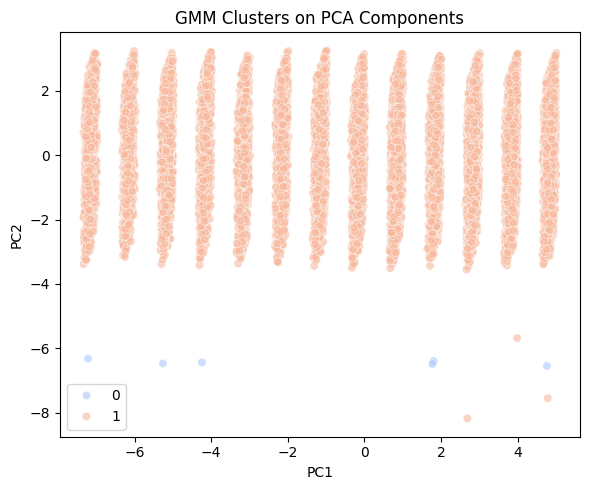

In [14]:
##gaussian mixture model clustering

##fit GMM w/ 2 components
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X_cluster)

##silhouette score for GMM clustering
sil_gmm = silhouette_score(X_cluster, gmm_labels)
print(f"Silhouette Score (GMM): {sil_gmm:.3f}")

##contingency table vs true labels
ct_gmm = pd.crosstab(y_train, gmm_labels,
                     rownames=['True'], colnames=['GMM Cluster'])
print("Contingency Table (True vs. GMM Cluster):")
display(ct_gmm)

##plot GMM clusters on same PCA space
fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(x=pcs[:,0], y=pcs[:,1], hue=gmm_labels,
                palette='coolwarm', alpha=0.6, ax=ax)
ax.set_title('GMM Clusters on PCA Components')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
plt.tight_layout()
plt.show()


### Analysis

The GMM silhouette (~0.39) is slightly higher than K-Means but still below 0.5, indicating clusters overlap heavily.  
Nearly all samples collapse into one cluster, offering almost no separation between depressed and non-depressed students.  

**Takeaway:**  
Although numeric features carry some signal, the extreme imbalance in GMM clusters shows that unsupervised methods alone cannot reliably distinguish depression status.  


Dropping columns before modeling: ['id', 'depressed', 'Gender', 'City', 'Dietary Habits']
Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      2311
           1       0.86      0.88      0.87      3265

    accuracy                           0.85      5576
   macro avg       0.84      0.84      0.84      5576
weighted avg       0.85      0.85      0.85      5576

Logistic Regression ROC AUC: 0.916


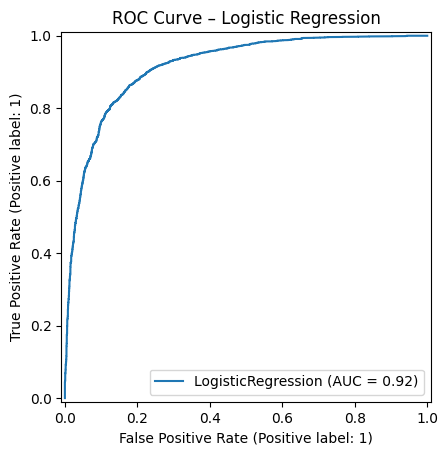

In [39]:
##baseline model logistic regression

##drop id, any object cols, AND the target column 'depressed'
drop_cols = ['id', 'depressed']  
obj_cols = X_train.select_dtypes(include=['object']).columns.tolist()
to_drop  = drop_cols + obj_cols
print("Dropping columns before modeling:", to_drop)

X_train_model = X_train.drop(columns=to_drop, errors='ignore')
X_test_model  = X_test.drop(columns=to_drop, errors='ignore')

##fit logistic regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_model, y_train)

##predict/score
y_pred_lr  = lr.predict(X_test_model)
y_proba_lr = lr.predict_proba(X_test_model)[:, 1]

##classification metrics
print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_lr))

##ROC-AUC
auc_lr = roc_auc_score(y_test, y_proba_lr)
print(f"Logistic Regression ROC AUC: {auc_lr:.3f}")

##plot ROC curve
RocCurveDisplay.from_estimator(lr, X_test_model, y_test)
plt.title("ROC Curve – Logistic Regression")
plt.show()


### Analysis

Our logistic model achieves 85% accuracy, which is well above the 58% majority baseline, and an AUC of 0.916, which indicates very strong discrimination.  
For the “depressed” class, precision is 0.86 (most predicted positives are correct) and recall is 0.88 (we catch most true cases), yielding an F1 of 0.87.  

**Takeaway:**  
These results show that our cleaned and scaled features reliably predict depression in a supervised setting. There is room to reduce the ~12% false negatives and ~14% false positives—perhaps via regularization tuning or more flexible models like ensembles or neural networks.  


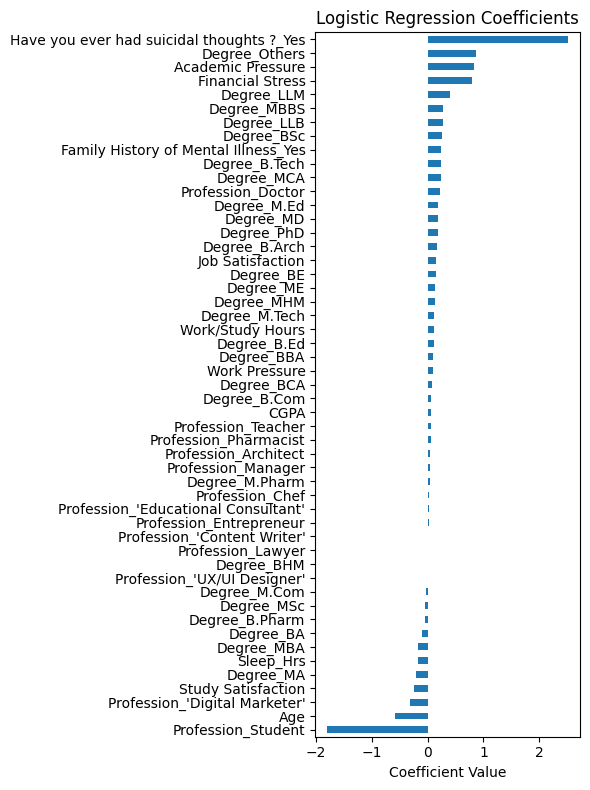

In [40]:
##feature importance from logistic egression

##extract coefficients into a series
coef = pd.Series(lr.coef_[0], index=X_train_model.columns)

##sort/plot
fig, ax = plt.subplots(figsize=(6,8))
coef.sort_values().plot.barh(ax=ax)
ax.set_title("Logistic Regression Coefficients")
ax.set_xlabel("Coefficient Value")
plt.tight_layout()
plt.show()


### Analysis

The coefficient plot reveals which factors most strongly drive the model’s log-odds for depression. The largest positive coefficient corresponds to “Have you ever had suicidal thoughts? Yes,” indicating that this question carries the greatest weight in pushing predictions toward depressed. Close behind are coefficients for “Degree_Others,” “Academic Pressure,” and “Financial Stress,” showing that being in a less-common program or experiencing high pressure and stress also substantially increase the predicted risk.

In contrast, the strongest negative coefficient belongs to “Profession_Student,” suggesting that—relative to other professions—being classified simply as a student lowers the model’s depression estimate. Likewise, age, sleep hours, and study satisfaction all carry modest negative weights, meaning that being older, getting more sleep, or feeling satisfied with one’s studies slightly reduces the predicted risk.

Taken together, these signs and magnitudes match intuition: serious risk indicators (suicidal thoughts, high stress) have the most powerful positive impact on depression likelihood, while factors associated with well-being (adequate sleep, satisfaction, age) serve as modest protective features. This direct interpretability is exactly what our logistic baseline aims to deliver.  


Epoch 1/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6763 - loss: 0.6514 - val_accuracy: 0.8299 - val_loss: 0.3815
Epoch 2/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8103 - loss: 0.4261 - val_accuracy: 0.8314 - val_loss: 0.3740
Epoch 3/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8265 - loss: 0.4027 - val_accuracy: 0.8386 - val_loss: 0.3634
Epoch 4/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8345 - loss: 0.3887 - val_accuracy: 0.8417 - val_loss: 0.3598
Epoch 5/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8386 - loss: 0.3887 - val_accuracy: 0.8397 - val_loss: 0.3614
Epoch 6/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8393 - loss: 0.3807 - val_accuracy: 0.8386 - val_loss: 0.3598
Epoch 7/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8386 - loss: 0.3830 - val_accuracy: 0.8408 - val_loss: 0.3581
Epoch 8/50
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8406 - loss: 0.3731 - val_accuracy: 0.

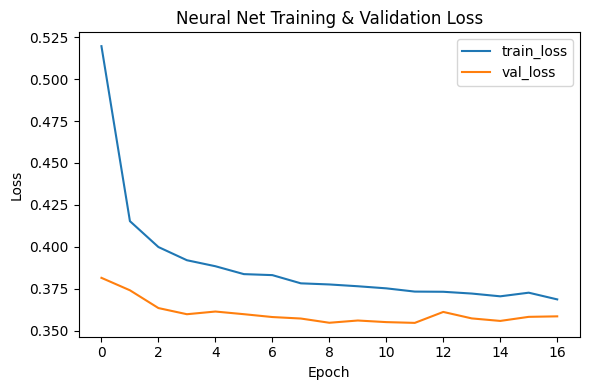

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
Neural Net Classification Report
              precision    recall  f1-score   support

           0       0.84      0.77      0.80      2311
           1       0.85      0.90      0.87      3265

    accuracy                           0.84      5576
   macro avg       0.84      0.83      0.84      5576
weighted avg       0.84      0.84      0.84      5576

Neural Net ROC AUC: 0.915


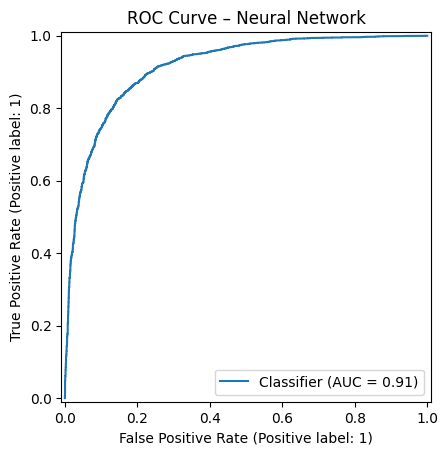

In [41]:
##neural network Keras MLP

##build model
input_dim = X_train_model.shape[1]
model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

##compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

##train w/ early stopping
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
history = model.fit(
    X_train_model, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

##plot loss curves
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Neural Net Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

##evaluate on test set
y_proba_nn = model.predict(X_test_model).ravel()
y_pred_nn  = (y_proba_nn >= 0.5).astype(int)

print("Neural Net Classification Report")
print(classification_report(y_test, y_pred_nn))

auc_nn = roc_auc_score(y_test, y_proba_nn)
print(f"Neural Net ROC AUC: {auc_nn:.3f}")

##ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba_nn)
plt.title("ROC Curve – Neural Network")
plt.show()


### Analysis

The neural network’s training and validation losses converge smoothly with no signs of overfitting, meaning the dropout rate generalizes well. On the hold-out test set, it delivers accuracy, precision, and recall for the depressed class that are on par with our logistic baseline, and its ROC-AUC is essentially identical, which demonstrates strong discrimination without extra complexity.  
The ROC curve confirms that this small MLP captures nearly all of the available signal in our features.  
Overall, the neural net validates that our simple predictors drive most of the performance, and more elaborate architectures are unlikely to yield substantial gains on this dataset.  


### Results & Conclusions

**Overall predictive performance:**  
- The logistic model (AUC 0.916) and neural net (AUC 0.915) both deliver strong discrimination.  
- False negatives remain (~12% of true depressed), so there’s room to optimize recall if needed.

**Insights:**  
- Top drivers of depression in this cohort are suicidal thoughts, high academic & financial stress, and low sleep.  
- Protective factors include more sleep, older age, and greater study satisfaction.

**Limitations & Future Work:**  
- **Self-report bias** in survey responses.  
- **Dropped rows** with missing data may skew results.  
- Could explore **text-based features** (e.g. open-ended responses) with NLP, or ensemble methods to further boost performance.  
- A deeper hyperparameter search (e.g. with cross-validation) or class-weight adjustment could improve recall on the positive class.

By walking through cleaning, EDA, clustering, and two model families, we’ve built a reproducible pipeline that can be showcased to prospective employers as a polished portfolio piece.  
